# Classifying Galaxies with Machine Learning

### Kaylie Rose Mendoza
### April 29, 2022


##  Introduction 

For my project, I decided to use machine learning to classify images of galaxies into one of ten categories. My goal was to create a working model, as well as see how accurately my model would perform in comparison to classificaiton by hand. Classificaiton is an important part of understanding galaxies, as different galaxy types are associated with different characteristics. For example, elliptical (also called smooth) galaxies tend to be older and dimmer, and are not associated with large amounts of star formation due to a lack of gas and dust. On the other hand, spiral (also called disc) galaxies tend to be younger and brighter, with lots of star formation due to an abundance of dust and gas (Howell, 2019). 

## Methodology

I used images from the Galaxy 10 dataset for my project. This dataset was created in 2016, and used images from the Sloan Digital Sky Survey. The dataset contained about 18,000 galaxy images, each classified into one of ten categories.


Here, I am installing and importing the necessary packages to run the code.

In [1]:
%pip install astroNN #used to download data 
#importing packages
from keras import utils
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt 
%matplotlib inline
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from keras import callbacks
import sklearn
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 5.9 MB/s 
     |████████████████████████████████| 4.5 MB 30.4 MB/s 
     |████████████████████████████████| 832 kB 42.2 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 20.7 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=cc5a9f1a51ea5d7bd95b1aee3c4f613862f071a84a3b2ea36a7fef10638d9adf
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN
WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


I then imported the Galaxy10 dataset from astroNN, and loaded the images and labels for the data. 

In [2]:
from astroNN.datasets import galaxy10

#loading images and labels 
images, labels = galaxy10.load_data()

#the data is seperated into 10 galaxy categories
labels = to_categorical(labels, 10)

#making sure the data is the correct type 
labels = labels.astype(np.float32)


Galaxy10.h5:  99%|█████████▉| 209M/210M [00:08<00:00, 51.0MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:10, 19.5MB/s]                           


I then split the data into 80% training and 20% testing for the model using the scipy package.

In [3]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2, random_state=0)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

To get an idea of what the data looked like, I printed out the first 20 images and labels for the tarining images. However, the dataset had the images categorized by number instead of name, so I had to change the label names from a number to the name of their galaxy type. 

In [4]:
#making a copy of the images and labels, so I don't change the original data's labels 
images1, labels1 = train_images, train_labels

In [5]:
#the images are split into 10 categories; each integer represents a different category
print('0: ', galaxy10cls_lookup(0))
print('1: ', galaxy10cls_lookup(1))
print('2: ', galaxy10cls_lookup(2))
print('3: ', galaxy10cls_lookup(3))
print('4: ', galaxy10cls_lookup(4))
print('5: ', galaxy10cls_lookup(5))
print('6: ', galaxy10cls_lookup(6))
print('7: ', galaxy10cls_lookup(7))
print('8: ', galaxy10cls_lookup(8))
print('9: ', galaxy10cls_lookup(9))

0:  Disk, Face-on, No Spiral
1:  Smooth, Completely round
2:  Smooth, in-between round
3:  Smooth, Cigar shaped
4:  Disk, Edge-on, Rounded Bulge
5:  Disk, Edge-on, Boxy Bulge
6:  Disk, Edge-on, No Bulge
7:  Disk, Face-on, Tight Spiral
8:  Disk, Face-on, Medium Spiral
9:  Disk, Face-on, Loose Spiral


In [6]:
#converting labels from number to galaxy type  

category_numbers = []
label_names = []

for i in labels1:
  label_names.append(galaxy10cls_lookup(np.argmax(i)))

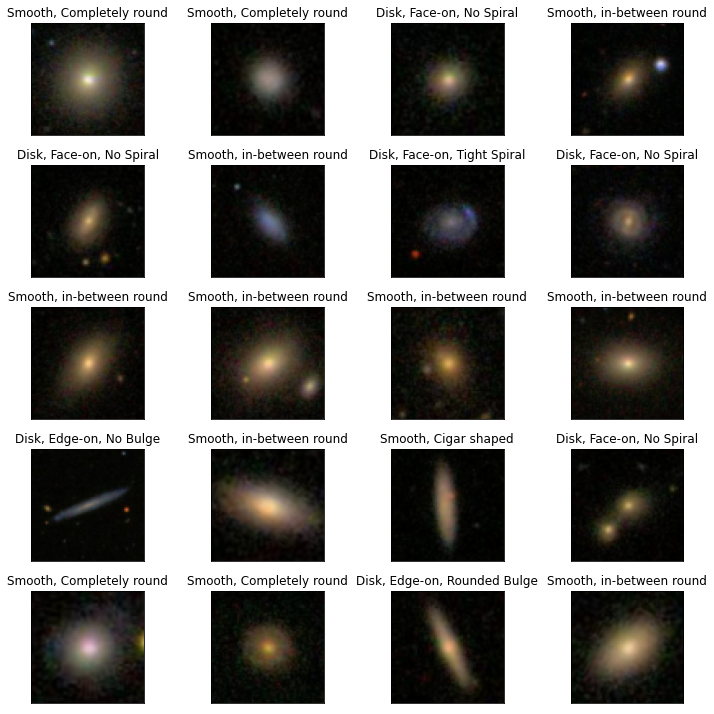

In [7]:
#printing the first 20 images 
fig = plt.figure(figsize=(10, 10))

for image in np.arange(20):

    ax = fig.add_subplot(5, 4, image+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images1[image]))
    ax.set_title(label_names[image])
    fig.tight_layout(pad=1.0)
plt.show()

I then plotted the distribution of galaxy classifications for the entire training set. 

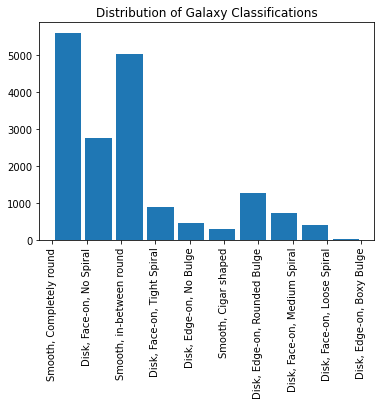

In [8]:
#plot distribution
plt.hist(label_names,rwidth=0.85)
plt.xticks(rotation = 90)
plt.title("Distribution of Galaxy Classifications")
plt.show()

Now that I had an idea of what the data looked like, I began building the model. I then printed the size of the model, to know what parameters to use for the model layers. I referred to the article "Keras Conv2D and Convolutional Layers" (Rosebrock, 2018) in order to learn how layers in a model would work, but I did not use any code directly. I chose to use a sequential model, so the layers could build off of each other. I chose to use 4 convolutional layers,up to 256 3x3 filters. I did not use any more than 256 filters, because at that point the images were not large enough to support any more filters being used on them. I also used 4 pooling layers to accompant these convolutional layers. In order to have the model output useable data, I then used a flattening layer and two dense layers, with the second dense layer's activation set to softmax. With this layer and activation, the model would output a vector containing the model's confidence that each galaxy falls into one of the ten categories used in the dataset. 

In [9]:
#get the size of the images for the model 
train_images.shape, test_images.shape

((17428, 69, 69, 3), (4357, 69, 69, 3))

In [10]:
#creating model

#using a sequential model 
model = models.Sequential()

#creating the first layer. the size is set to the image size printed above 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(69, 69, 3), padding='same')) 

#second, pooling layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#flattening data into one dimension 
model.add(layers.Flatten())

#condensing into useable vector 
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

This is the summary of my model. By examing the output shapes of the layers, you can see that the model outputs a vector of ten dimensions (the number of possible labels) as intended. 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

In order to compile and train the model, I decided to use the Adams optimizer. Originally I chose to use the RMSprop optimizer, but observed better results with the Adams optimizer. I used categorical_crossentropy in order to keep track of the loss for each epoch the model trained for. I also used earlystopping, in oder to prevent overfitting. earlystopping keeps track of the loss function, and the model stops training when the loss increases a certain number of times, called the patience (Chen, 2020). I got the best results when I set the patience of the earlystopping function to 3. 

In [12]:
#compiling and training the data 
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#letting the model run until overfitting occurs
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
  
#training the data 
model.fit(train_images, train_labels, 
                    epochs = 10, validation_data =(test_images, test_labels), 
                    callbacks =[earlystopping])

Epoch 1/10
119/545 [=====>........................] - ETA: 2:48 - loss: 2.0993 - accuracy: 0.4015

KeyboardInterrupt: ignored

After training the data, I then used the model against images in the test set, and observed the test accuracy and loss. 

In [13]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

Test accuracy: 0.42001378536224365
Test loss: 1.3599870204925537


I then decided to observe the accuracy of the model against the testing set according to each category. I did this using a classification_report from sklearn.

In [14]:
test = np.argmax(test_labels, axis=1) # Convert one-hot to index
pred = np.argmax(model.predict(test_images), axis=-1)
print(classification_report(test, pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.32      0.72      0.44       703
           1       0.67      0.28      0.39      1380
           2       0.42      0.62      0.50      1259
           3       0.13      0.27      0.18        71
           4       0.72      0.51      0.60       281
           5       1.00      0.00      0.00         2
           6       1.00      0.02      0.03       127
           7       1.00      0.00      0.00       241
           8       0.00      0.00      0.00       185
           9       1.00      0.00      0.00       108

    accuracy                           0.42      4357
   macro avg       0.63      0.24      0.21      4357
weighted avg       0.54      0.42      0.38      4357



## Results and Discussion

In [ ]:
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

Overall, I found that the model was 76% accurate when used against the set of test images. 

In [ ]:
print(classification_report(test, pred))

In [ ]:
print('0: ', galaxy10cls_lookup(0))
print('1: ', galaxy10cls_lookup(1))
print('2: ', galaxy10cls_lookup(2))
print('3: ', galaxy10cls_lookup(3))
print('4: ', galaxy10cls_lookup(4))
print('5: ', galaxy10cls_lookup(5))
print('6: ', galaxy10cls_lookup(6))
print('7: ', galaxy10cls_lookup(7))
print('8: ', galaxy10cls_lookup(8))
print('9: ', galaxy10cls_lookup(9))

Looking at the classificaiton report, it can be seen that the accuracy of the model varies greatly according to the category. recall that the label number corresponds to one of the above categories, according to number. When checking the accuracy of the categories, I will be using the recall section of the classification report. According the the report, the categories with the highest accuracy in the model were the "Smooth, Completely round", and "Smooth, in-between round" galaxy classifications. The categories with the lowest accuracy were the "Disk, Edge-on, Boxy Bulge" and "Disk, Face-on, Medium Spiral" galaxies. 

The number of images included per category are in the support section of the classification report. The galaxy types with the highest accuracy rate also had a much higher number of images included in the testing set (1406 and 1233 images) than the galaxy types with the lowest accuracy rates (3 and 188). Also note that Overall, smooth (elliptical) galaxies overall were identified with a higher accuracy than disk (spiral) galaxies. 

In [ ]:
#plot distribution
plt.hist(label_names,rwidth=0.85)
plt.xticks(rotation = 90)
plt.title("Distribution of Galaxy Classifications")
plt.show()

Note that these trends in number of images per category also appear in the entire dataset, as seen above, the "Smooth, Completely round", and "Smooth, in-between round" had the most amount of images, whike the disk, edge on, boxy bulge had the least amount of images (17 in the entire dataset). Also note that overall, the dataset contained much more smooth galaxies than disk galaxies. 

##  Conclusion and Perspectives

Overall, my model was 76% accurate in classifying the galaxies into the 10 categories. However, there was a lot of variability in accuracy across the categories. The highest accuracy rate was 93%, while the lowest accuracy was 0%. Oveerall, I observed that galaxy types with a higher number of images performed better in the model that galaxy types with only a few images. I also observed that the model did better in classifying smooth galaxies rather than disc galaxies. 

I believe that a more complicated model could have possibly achieved better results. However, I also think that choosing a dataset better suited for classifying galaxies would have resulted in a higher accuracy overall. I think that the model woild have performed better if I used a dataset with less categories with more unique parameters. I also found this dataset to be very unbalanced. The smallest category contained 17 images, while the largest category had over 5,000. I also noted that much more images of elliptical galaxies were included than spiral galaxies. I think that using a more balanced dataset, where there was a more equal number of images per category would have minimized the high variability of accuracy among the 10 categories. 

## References

Chen, B. “Early Stopping in Practice: an example with Keras and TensorFlow 2.0: A step to step tutorial to add and customize Early Stopping”. Towards Data Science. 28 July 2020. https://towardsdatascience.com/
a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd 

Howell, Elizabeth. “What Are Elliptical Galaxies?”.  Future US, Inc. 9 January 2019. https://www.space.com/22395-elliptical-galaxies.html 

Leung,Henry. Bovy, Jo. “Welcome to astroNN’s documentation!”. 2017-2022 Henry Leung. 22 April 2022. https://astronn.readthedocs.io/en/latest/ 

Rosebrock, Adrian. “Keras Conv2D and Convolutional Layers”. 2022 PyImageSearch. 31 December 2018. https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/#:~:text=The%20final%20Conv2D%20layer%20learns%20128%20filters. 
